# Single Echo Hiding

Hide a single constant echo in a large chunk of audio

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from matplotlib.textpath import TextPath
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

import IPython.display as ipd
from scipy.io import wavfile
from echohiding import echo_hide_single, get_cepstrum, extract_echo_bits
from audioutils import get_odg_distortion, get_mp3_encoded
from binutils import *

In [ ]:
# Load audio samples from a randomly chosen example from OpenMic Dataset
sr, x = wavfile.read("086799_0.wav")
x = np.mean(x, axis=1) # Mix to mono
x = x/32768 # Put in range [-1, 1]
ipd.Audio(x, rate=sr)

In [ ]:
# Hide echoes. A higher alpha will make the echoes more obvious
delta = 75
alpha = 0.2
y = echo_hide_single(x, delta, alpha)
ipd.Audio(y, rate=sr)

In [4]:
# Imperceptibility (using Holters GstPEAQ)
odg, di = get_odg_distortion(x, y, sr)
print("Objective difference grade: {:.3f}".format(odg))
print("Distortion index: {:.3f}".format(di))

Objective difference grade: -2.706
Distortion index: -0.831


## Analysis #1: Full Cepstrum

First, examine the cepstrum over all of the audio restricted to a small echo range.
Report its p-value in that range, and whether it achieves the max in that range

delta is max in range:  True
p value:  2.220446049250313e-16


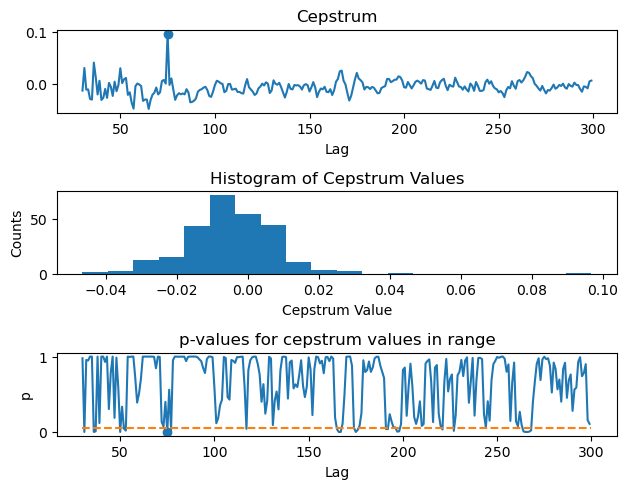

In [5]:
def get_pvalue(x, idx):
    """
    Compute the p-value of an array at an index with
    respect to the distribution excluding that index
    """
    import scipy.stats as st
    y = np.concatenate((x[0:idx], x[idx+1:]))
    mu = np.mean(y)
    std = np.std(y)
    return 1-st.norm.cdf((x[idx]-mu)/std)


# Range of lags in cepstrum to consider
mn = 30
mx = 300

c = get_cepstrum(y)

plt.subplot(311)
plt.plot(np.arange(mn, mx), c[mn:mx])
plt.scatter([delta], [c[delta]])
plt.title("Cepstrum")
plt.xlabel("Lag")

plt.subplot(312)
plt.hist(c[mn:mx], 20);
plt.xlabel("Cepstrum Value")
plt.ylabel("Counts")
plt.title("Histogram of Cepstrum Values")

plt.subplot(313)
plt.plot(np.arange(mn, mx), [get_pvalue(c, i) for i in range(mn, mx)])
plt.tight_layout()
plt.xlabel("Lag")
plt.ylabel("p")
plt.title("p-values for cepstrum values in range")

## Print if the offset delta achieves the maximum index in the cepstrum at this range
print("delta is max in range: ", (delta-mn) == np.argmax(c[mn:mx]))
p = get_pvalue(c[mn:mx], delta-mn)
plt.plot([mn, mx], [0.05, 0.05], linestyle='--') # The ordained p-value cutoff
print("p value: ", p)
plt.scatter([delta], [p])

## Analysis #2: Bits in Different Windows

Now we'll vary the window size and see how many of the bits ended up as a 1 when we consider a lag of 50 to be a 0 (for the sake of argument)

Text(0, 0.5, "Proportion of 1's")

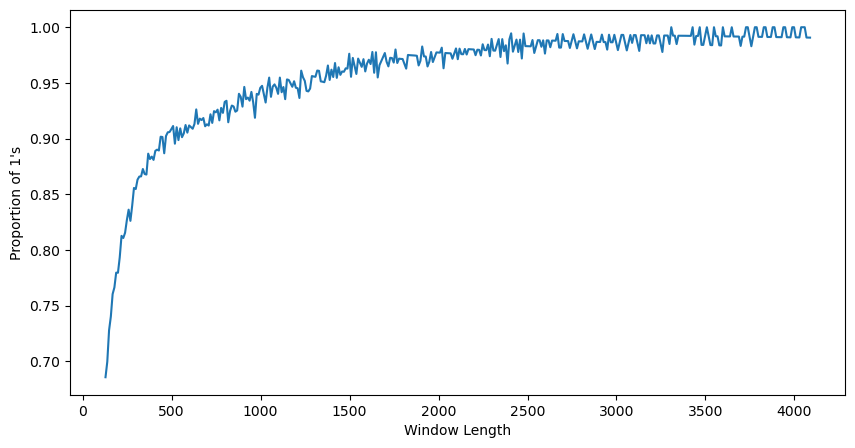

In [6]:
wins = np.arange(128, 4096, 10)
proportions = np.zeros(wins.size)

delta0 = 50
for i, L in enumerate(wins):
    b = extract_echo_bits(y, L, 50, delta)
    proportions[i] = np.sum(b)/b.size
plt.figure(figsize=(10, 5))
plt.plot(wins, proportions)
plt.xlabel("Window Length")
plt.ylabel("Proportion of 1's")